# Introduction

In this notebook, we're going to load a dataset I manually created regarding audible books. We'll explore the dataset and then build a machine learning pipeline and create a machine learning model to help with the decision if it's good to spend a credit on a book, or just buy with cash and use the discount you're already getting.

In [1]:
# Lets import the libraries and load the data
import pandas as pd
import time
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


df = pd.read_csv('data.csv')
df.head()

,price,hours,minutes,credit_spent
0,24.46,13.0,15.0,1.0
1,19.60,6.0,57.0,0.0
2,19.60,5.0,21.0,0.0
3,19.60,6.0,0.0,0.0
4,24.46,13.0,54.0,1.0


The dataset has 4 features:

1. Price: The price members pay if they want to buy the book with real money.
2. Hours: The book length in hours. If a book length is 11 hours and 30 minutes, this would be 11.
3. Minutes: The minutes after the last hour in a book. If a book  is 11 hours and 30 minutes in length, this would be 30.
4. Credit_spent: This labels if I ended up spending a credit on the book or not. 0 for no, 1 for yes.

As for data cleaning, the dataset is already clean enough. Since I manually collected it myself, I was working to make it as clean as possible from the start.

I also know that the dataset has price duplicates, but the other features, (hours and minutes) have diffrent values for those columns as well. What I mean is, You may find more than one book for $17.49, however, for each one of those books, the hours and minutes values are different, thus being unique on their own.

However, we still need to do some data wrangling. As you can see, we have the hours and minutes data columns. What we'll do is we'll combine them into one column called duration, and then drop the columns we don't need anymore.

In [2]:
df['duration'] = ((df['hours']*60)+df['minutes'])/60
df.head()

,price,hours,minutes,credit_spent,duration
0,24.46,13.0,15.0,1.0,13.25
1,19.60,6.0,57.0,0.0,6.95
2,19.60,5.0,21.0,0.0,5.35
3,19.60,6.0,0.0,0.0,6.00
4,24.46,13.0,54.0,1.0,13.90


Now we'll drop the minutes and hours columns since we don't need them anymore

In [3]:
# Drop unneeded columns
df.drop(columns=['hours', 'minutes'], axis=1, inplace=True)
df.head()

,price,credit_spent,duration
0,24.46,1.0,13.25
1,19.60,0.0,6.95
2,19.60,0.0,5.35
3,19.60,0.0,6.00
4,24.46,1.0,13.90


# Part 1: Data exploration

We'll check a few descriptive stitistics here

In [4]:
#Look at the dataset shape
df.shape

(100, 3)

In [5]:
#Describe the price column
df['price'].describe()

count    100.000000
mean      21.666200
std        8.865478
min        2.760000
25%       14.690000
50%       19.600000
75%       24.735000
max       46.990000
Name: price, dtype: float64

In [6]:
#Describe the duration column
df['duration'].describe()

count    100.000000
mean      18.257500
std       11.339024
min        1.050000
25%        9.745833
50%       14.891667
75%       24.833333
max       55.083333
Name: duration, dtype: float64

Text(0, 0.5, 'Count')

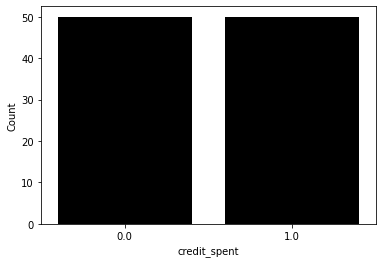

In [7]:
# Graph with credit spending
sns.countplot(data=df, x='credit_spent', color='black')
plt.xlabel('credit_spent')
plt.ylabel('Count')

# Part 2: Model pipeline

We'll create a few functions that make the model pipeline, evaluate it, and then save it.

When we build the model pipeline, we'll use GridSearchCV. We'll use it because the way it works, we give it a few parameters like a grid, and then it it combines them together in every possible way, giving us the best values hopefully.

In [8]:
def build_model(solution=2):
    '''
    Builds a model with a pipeline.

    Doesn't accept any args.

    Returns a GridSearch object.
    '''
    pipeline = Pipeline([
        ('clf', RandomForestClassifier())
    ])
    print(RandomForestClassifier().get_params().keys())
    if solution == 1:
        parameters = {
            'clf__max_depth': [10, 10, 10],
            'clf__n_estimators': [10, 10, 10],
            'clf__min_samples_split': [2, 3, 4],
            'clf__random_state': [42],
            'clf__max_leaf_nodes': [10, 10, 10]
        }
    if solution == 2:
        parameters = {
            'clf__max_depth': [1, 5, 10],
            'clf__n_estimators': [1, 5, 10],
            'clf__min_samples_split': [2, 3, 4],
            'clf__random_state': [42],
            'clf__max_leaf_nodes': [2, 5, 10]
        }

    cv = GridSearchCV(pipeline, param_grid=parameters, verbose=3)
    return cv

We need a function to evaluate the model after creating it, so we'll create one. We'll use accuracy_score to measure how well the model is performing because we want to know the accuracy of the model when dealing with unseen data. The accuracy_score gives us just that.

In [9]:
def evaluate_model(model, X_test, Y_test):
    '''
    evaluates the model.

    Input:
    model - the model you want to be evaluated.
    X_test - A dataframe with the testing features.
    Y_test - A dataframe with the testing labels.

    '''
    Y_pred = model.predict(X_test)
    print('{}%'.format(round(accuracy_score(Y_test, Y_pred), 2)*100))

Now we'll create a function to save the model so we don't have to train it everytime.

In [10]:
def save_model(model, model_filepath):
    '''Saves the model into the path specified.'''
    pickle.dump(model, open(model_filepath, 'wb'))

# Part 3: Training the model

It's time for us to train the model, now this might take sometime depending on your machine, but overall this shouldn't take this long because this dataset is small.

We first need to set the features and labels

In [11]:
X = df[['price', 'duration']]
Y = df['credit_spent']

In [12]:
# Split the dataset into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

Now we need to build the model. The build_model function contains the hyper parameters for tuning the model. I preserved some of the old parameters I used before so we can compare them for presentation's sake. Lets check the parameters that didn't do well first. We do that by passing solution=1 to the function, to tell it we need to use the old parameters.

In [13]:
model = build_model(solution=1)

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])


We'll train the model to see how well it does

In [14]:
print('Training model...')
start = time.time()
model.fit(X_train, Y_train)
print('Training took {} minutes'.format(round((time.time() - start)/60, 2)))
print('Evaluating model...')
evaluate_model(model, X_test, Y_test)

Training model...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=42;, score=0.750 total time=   0.0s
[CV 2/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=42;, score=1.000 total time=   0.0s
[CV 3/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=42;, score=0.812 total time=   0.0s
[CV 4/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 5/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 1/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=42;, sco

[CV 1/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=3, clf__n_estimators=10, clf__random_state=42;, score=0.750 total time=   0.0s
[CV 2/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=3, clf__n_estimators=10, clf__random_state=42;, score=1.000 total time=   0.0s
[CV 3/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=3, clf__n_estimators=10, clf__random_state=42;, score=0.812 total time=   0.0s
[CV 4/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=3, clf__n_estimators=10, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 5/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=3, clf__n_estimators=10, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 1/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=3, clf__n_estimators=10, clf__random_state=42;, score=0.750 total time=   0.0s
[CV 2/5] END clf__max_depth=10, clf__max_leaf_nodes=

[CV 4/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=3, clf__n_estimators=10, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 5/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=3, clf__n_estimators=10, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 1/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=3, clf__n_estimators=10, clf__random_state=42;, score=0.750 total time=   0.0s
[CV 2/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=3, clf__n_estimators=10, clf__random_state=42;, score=1.000 total time=   0.0s
[CV 3/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=3, clf__n_estimators=10, clf__random_state=42;, score=0.812 total time=   0.0s
[CV 4/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=3, clf__n_estimators=10, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 5/5] END clf__max_depth=10, clf__max_leaf_nodes=

[CV 2/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=4, clf__n_estimators=10, clf__random_state=42;, score=1.000 total time=   0.0s
[CV 3/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=4, clf__n_estimators=10, clf__random_state=42;, score=0.812 total time=   0.0s
[CV 4/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=4, clf__n_estimators=10, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 5/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=4, clf__n_estimators=10, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 1/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=4, clf__n_estimators=10, clf__random_state=42;, score=0.750 total time=   0.0s
[CV 2/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=4, clf__n_estimators=10, clf__random_state=42;, score=1.000 total time=   0.0s
[CV 3/5] END clf__max_depth=10, clf__max_leaf_nodes=

[CV 1/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=4, clf__n_estimators=10, clf__random_state=42;, score=0.750 total time=   0.0s
[CV 2/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=4, clf__n_estimators=10, clf__random_state=42;, score=1.000 total time=   0.0s
[CV 3/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=4, clf__n_estimators=10, clf__random_state=42;, score=0.812 total time=   0.0s
[CV 4/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=4, clf__n_estimators=10, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 5/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=4, clf__n_estimators=10, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 1/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=42;, score=0.750 total time=   0.0s
[CV 2/5] END clf__max_depth=10, clf__max_leaf_nodes=

[CV 3/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=42;, score=0.812 total time=   0.0s
[CV 4/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 5/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 1/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=42;, score=0.750 total time=   0.0s
[CV 2/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=42;, score=1.000 total time=   0.0s
[CV 3/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=42;, score=0.812 total time=   0.0s
[CV 4/5] END clf__max_depth=10, clf__max_leaf_nodes=

[CV 5/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 1/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=42;, score=0.750 total time=   0.0s
[CV 2/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=42;, score=1.000 total time=   0.0s
[CV 3/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=42;, score=0.812 total time=   0.0s
[CV 4/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 5/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 1/5] END clf__max_depth=10, clf__max_leaf_nodes=

[CV 4/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=3, clf__n_estimators=10, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 5/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=3, clf__n_estimators=10, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 1/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=3, clf__n_estimators=10, clf__random_state=42;, score=0.750 total time=   0.0s
[CV 2/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=3, clf__n_estimators=10, clf__random_state=42;, score=1.000 total time=   0.0s
[CV 3/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=3, clf__n_estimators=10, clf__random_state=42;, score=0.812 total time=   0.0s
[CV 4/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=3, clf__n_estimators=10, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 5/5] END clf__max_depth=10, clf__max_leaf_nodes=

We'll check the other solution that actually did better interms of the training time.

In [15]:
model = build_model()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])


We'll train the model to see how well it does

In [16]:
print('Training model...')
start = time.time()
model.fit(X_train, Y_train)
print('Training took {} minutes'.format(round((time.time() - start)/60, 2)))
print('Evaluating model...')
evaluate_model(model, X_test, Y_test)

Training model...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END clf__max_depth=1, clf__max_leaf_nodes=2, clf__min_samples_split=2, clf__n_estimators=1, clf__random_state=42;, score=0.750 total time=   0.0s
[CV 2/5] END clf__max_depth=1, clf__max_leaf_nodes=2, clf__min_samples_split=2, clf__n_estimators=1, clf__random_state=42;, score=0.812 total time=   0.0s
[CV 3/5] END clf__max_depth=1, clf__max_leaf_nodes=2, clf__min_samples_split=2, clf__n_estimators=1, clf__random_state=42;, score=0.875 total time=   0.0s
[CV 4/5] END clf__max_depth=1, clf__max_leaf_nodes=2, clf__min_samples_split=2, clf__n_estimators=1, clf__random_state=42;, score=0.500 total time=   0.0s
[CV 5/5] END clf__max_depth=1, clf__max_leaf_nodes=2, clf__min_samples_split=2, clf__n_estimators=1, clf__random_state=42;, score=0.750 total time=   0.0s
[CV 1/5] END clf__max_depth=1, clf__max_leaf_nodes=2, clf__min_samples_split=2, clf__n_estimators=5, clf__random_state=42;, score=0.875 total tim

[CV 3/5] END clf__max_depth=1, clf__max_leaf_nodes=5, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 4/5] END clf__max_depth=1, clf__max_leaf_nodes=5, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 5/5] END clf__max_depth=1, clf__max_leaf_nodes=5, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 1/5] END clf__max_depth=1, clf__max_leaf_nodes=5, clf__min_samples_split=3, clf__n_estimators=1, clf__random_state=42;, score=0.750 total time=   0.0s
[CV 2/5] END clf__max_depth=1, clf__max_leaf_nodes=5, clf__min_samples_split=3, clf__n_estimators=1, clf__random_state=42;, score=0.812 total time=   0.0s
[CV 3/5] END clf__max_depth=1, clf__max_leaf_nodes=5, clf__min_samples_split=3, clf__n_estimators=1, clf__random_state=42;, score=0.875 total time=   0.0s
[CV 4/5] END clf__max_depth=1, clf__max_leaf_nodes=5, clf__min_samp

[CV 4/5] END clf__max_depth=1, clf__max_leaf_nodes=10, clf__min_samples_split=3, clf__n_estimators=10, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 5/5] END clf__max_depth=1, clf__max_leaf_nodes=10, clf__min_samples_split=3, clf__n_estimators=10, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 1/5] END clf__max_depth=1, clf__max_leaf_nodes=10, clf__min_samples_split=4, clf__n_estimators=1, clf__random_state=42;, score=0.750 total time=   0.0s
[CV 2/5] END clf__max_depth=1, clf__max_leaf_nodes=10, clf__min_samples_split=4, clf__n_estimators=1, clf__random_state=42;, score=0.812 total time=   0.0s
[CV 3/5] END clf__max_depth=1, clf__max_leaf_nodes=10, clf__min_samples_split=4, clf__n_estimators=1, clf__random_state=42;, score=0.875 total time=   0.0s
[CV 4/5] END clf__max_depth=1, clf__max_leaf_nodes=10, clf__min_samples_split=4, clf__n_estimators=1, clf__random_state=42;, score=0.500 total time=   0.0s
[CV 5/5] END clf__max_depth=1, clf__max_leaf_nodes=10, clf__mi

[CV 3/5] END clf__max_depth=5, clf__max_leaf_nodes=2, clf__min_samples_split=4, clf__n_estimators=5, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 4/5] END clf__max_depth=5, clf__max_leaf_nodes=2, clf__min_samples_split=4, clf__n_estimators=5, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 5/5] END clf__max_depth=5, clf__max_leaf_nodes=2, clf__min_samples_split=4, clf__n_estimators=5, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 1/5] END clf__max_depth=5, clf__max_leaf_nodes=2, clf__min_samples_split=4, clf__n_estimators=10, clf__random_state=42;, score=0.875 total time=   0.0s
[CV 2/5] END clf__max_depth=5, clf__max_leaf_nodes=2, clf__min_samples_split=4, clf__n_estimators=10, clf__random_state=42;, score=1.000 total time=   0.0s
[CV 3/5] END clf__max_depth=5, clf__max_leaf_nodes=2, clf__min_samples_split=4, clf__n_estimators=10, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 4/5] END clf__max_depth=5, clf__max_leaf_nodes=2, clf__min_samp

[CV 1/5] END clf__max_depth=5, clf__max_leaf_nodes=10, clf__min_samples_split=2, clf__n_estimators=5, clf__random_state=42;, score=0.750 total time=   0.0s
[CV 2/5] END clf__max_depth=5, clf__max_leaf_nodes=10, clf__min_samples_split=2, clf__n_estimators=5, clf__random_state=42;, score=1.000 total time=   0.0s
[CV 3/5] END clf__max_depth=5, clf__max_leaf_nodes=10, clf__min_samples_split=2, clf__n_estimators=5, clf__random_state=42;, score=0.812 total time=   0.0s
[CV 4/5] END clf__max_depth=5, clf__max_leaf_nodes=10, clf__min_samples_split=2, clf__n_estimators=5, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 5/5] END clf__max_depth=5, clf__max_leaf_nodes=10, clf__min_samples_split=2, clf__n_estimators=5, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 1/5] END clf__max_depth=5, clf__max_leaf_nodes=10, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=42;, score=0.750 total time=   0.0s
[CV 2/5] END clf__max_depth=5, clf__max_leaf_nodes=10, clf__min

[CV 1/5] END clf__max_depth=10, clf__max_leaf_nodes=2, clf__min_samples_split=3, clf__n_estimators=5, clf__random_state=42;, score=0.875 total time=   0.0s
[CV 2/5] END clf__max_depth=10, clf__max_leaf_nodes=2, clf__min_samples_split=3, clf__n_estimators=5, clf__random_state=42;, score=1.000 total time=   0.0s
[CV 3/5] END clf__max_depth=10, clf__max_leaf_nodes=2, clf__min_samples_split=3, clf__n_estimators=5, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 4/5] END clf__max_depth=10, clf__max_leaf_nodes=2, clf__min_samples_split=3, clf__n_estimators=5, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 5/5] END clf__max_depth=10, clf__max_leaf_nodes=2, clf__min_samples_split=3, clf__n_estimators=5, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 1/5] END clf__max_depth=10, clf__max_leaf_nodes=2, clf__min_samples_split=3, clf__n_estimators=10, clf__random_state=42;, score=0.875 total time=   0.0s
[CV 2/5] END clf__max_depth=10, clf__max_leaf_nodes=2, clf__min

[CV 2/5] END clf__max_depth=10, clf__max_leaf_nodes=5, clf__min_samples_split=4, clf__n_estimators=5, clf__random_state=42;, score=1.000 total time=   0.0s
[CV 3/5] END clf__max_depth=10, clf__max_leaf_nodes=5, clf__min_samples_split=4, clf__n_estimators=5, clf__random_state=42;, score=0.812 total time=   0.0s
[CV 4/5] END clf__max_depth=10, clf__max_leaf_nodes=5, clf__min_samples_split=4, clf__n_estimators=5, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 5/5] END clf__max_depth=10, clf__max_leaf_nodes=5, clf__min_samples_split=4, clf__n_estimators=5, clf__random_state=42;, score=0.938 total time=   0.0s
[CV 1/5] END clf__max_depth=10, clf__max_leaf_nodes=5, clf__min_samples_split=4, clf__n_estimators=10, clf__random_state=42;, score=0.750 total time=   0.0s
[CV 2/5] END clf__max_depth=10, clf__max_leaf_nodes=5, clf__min_samples_split=4, clf__n_estimators=10, clf__random_state=42;, score=1.000 total time=   0.0s
[CV 3/5] END clf__max_depth=10, clf__max_leaf_nodes=5, clf__mi

[CV 5/5] END clf__max_depth=10, clf__max_leaf_nodes=10, clf__min_samples_split=4, clf__n_estimators=10, clf__random_state=42;, score=0.938 total time=   0.0s
Training took 0.09 minutes
Evaluating model...
100.0%


On my machine, the first solution took 0.14 minutes to train with 100% accuracy, while the second solution took 0.08 minutes to train also with 100% accuracy. The good thing is that the second solution took less time to traine with the same accuracy, thus making our pipeline go faster.
Since the second solution is better, we''l just save it.

In [17]:
print('Saving...')
save_model(model, 'model.pkl')
print('Model saved')

Saving...
Model saved


# The web app

I actually created a web app with flask that uses this model we just created. Just run the app.py file in the project folder after running all cells in this notebook. Then go to localhost:5000 and you'll get a web interface for you to test the model for yourself. For more info, checkout the README file.

# Conclusion

Throughout this project, I collected a dataset that contains some information about some books on audible, like their member price, and duration. I then labeled every book with if it's good to spend an audible credit on that book or not. I then started exploring the dataset on this notebook and made a machine learning model to hopefully help me and others to decide if it's a good idea to buy a book with a credit, or just use the 30% discount that comes with all audible memberships. As for difficulty, I think that collecting the data was the hardest part. It took me some time to gather everything and label every book. But I made a script to help with that, and it actually helped. As for the improvements, I'm honestly happy that I managed to get to 100% accuracy with my model, and for me that means I really did good with all the steps I did before, from data collection to building the machine learning pipeline and what not, however, I think that it could be deceiving just as much. I think I need more data to really test the model. For now I have just 100 books and it's enough for now, but I'd love me some data that go to other ranges of numbers too.